In [13]:
import os
import pandas as pd
import psycopg2

from dotenv import load_dotenv
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

import warnings
warnings.filterwarnings('ignore')

load_dotenv("../.env")

True

In [14]:
try:
    conn = psycopg2.connect(
        host="localhost",
        port=os.getenv("POSTGRES_PORT", 5432),
        database=os.getenv("POSTGRES_DB", "online_store"),
        user=os.getenv("POSTGRES_USER", "postgres"),
        password=os.getenv("POSTGRES_PASSWORD", "postgres")
    )
    print("Успешное подключение к базе данных")
except Exception as e:
    print(f"Ошибка подключения: {e}")
    conn = None

Успешное подключение к базе данных


# Общая статистика базы данных

In [15]:
query = """
SELECT 
    (SELECT COUNT(*) FROM users) as total_users,
    (SELECT COUNT(*) FROM champions) as total_champions,
    (SELECT COUNT(*) FROM matches) as total_matches,
    (SELECT COUNT(*) FROM match_participants) as total_participants
"""

df_stats = pd.read_sql(query, conn)
print(df_stats.to_string(index=False))

 total_users  total_champions  total_matches  total_participants
         395               50           1208               12080


# 2. ПИКРЕЙТ ЧЕМПИОНОВ (ТОП-15)

    champion  total_picks  pick_rate_percent
       Elise          277               2.29
Aurelion Sol          275               2.28
       Corki          276               2.28
   Dr. Mundo          263               2.18
      Kai'Sa          263               2.18
        Ahri          263               2.18
  Blitzcrank          260               2.15
    Cho Gath          259               2.14
     Evelynn          258               2.14
    Aphelios          258               2.14
       Galio          257               2.13
       Annie          257               2.13
      Irelia          257               2.13
      Darius          256               2.12
        Jinx          256               2.12


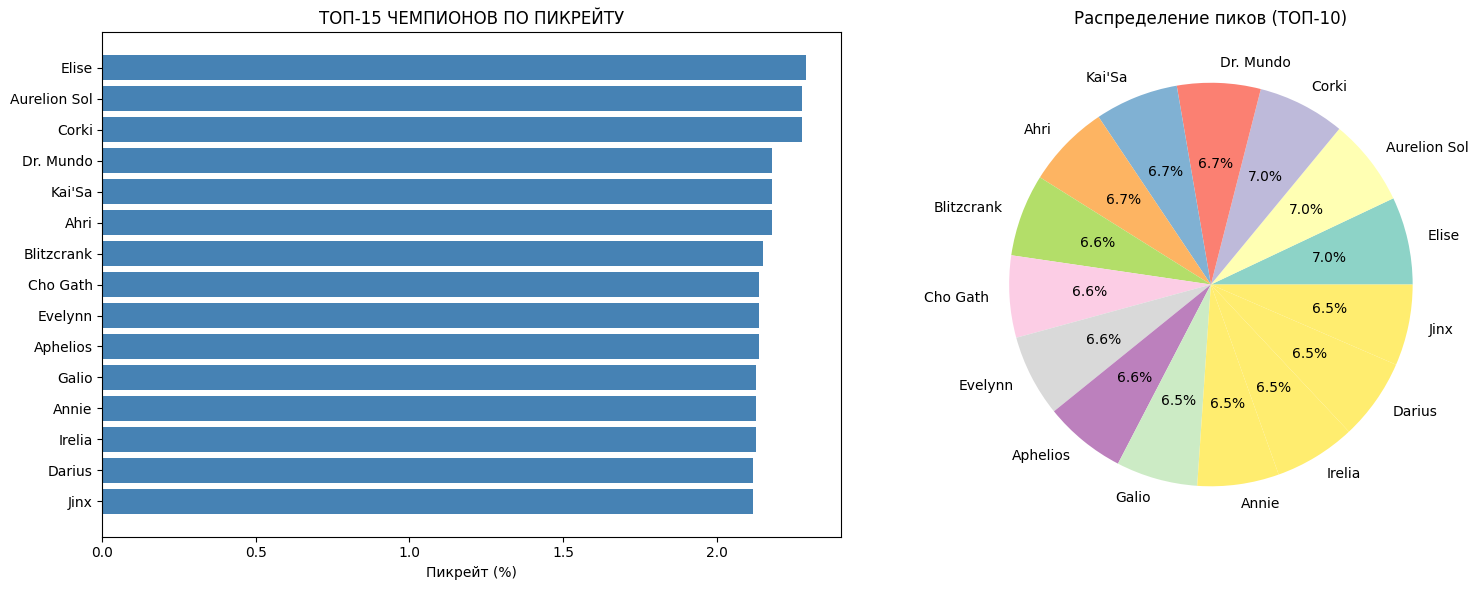

In [16]:
query = """
SELECT 
    c.name as champion,
    COUNT(*) as total_picks,
    ROUND(100.0 * COUNT(*) / (SELECT COUNT(*) FROM match_participants), 2) as pick_rate_percent
FROM match_participants mp
JOIN champions c ON mp.champion_id = c.id
GROUP BY c.id, c.name
ORDER BY pick_rate_percent DESC
LIMIT 15
"""

df_pickrate = pd.read_sql(query, conn)
print(df_pickrate.to_string(index=False))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.barh(df_pickrate['champion'], df_pickrate['pick_rate_percent'], color='steelblue')
ax1.set_xlabel('Пикрейт (%)')
ax1.set_title('ТОП-15 ЧЕМПИОНОВ ПО ПИКРЕЙТУ')
ax1.invert_yaxis()

top15 = df_pickrate.head(15)
colors = plt.cm.Set3(range(len(top15)))
ax2.pie(top15['pick_rate_percent'], labels=top15['champion'], autopct='%1.1f%%', colors=colors)
ax2.set_title('Распределение пиков (ТОП-10)')

plt.tight_layout()
plt.show()

# 3. ВИНРЕЙТ ИГРОКОВ (ТОП-10)

     player  total_matches  wins  losses  win_rate_percent
   Andre456             12    10       2             83.33
  Travis158             18    14       4             77.78
Kristine636             10     7       3             70.00
   Bonnie53             30    21       9             70.00
 Patrick154             10     7       3             70.00
Courtney869             10     7       3             70.00
    Erin288             41    28      13             68.29
   Brian889             37    24      13             64.86
  Joshua418             14     9       5             64.29
    Paul652             28    18      10             64.29


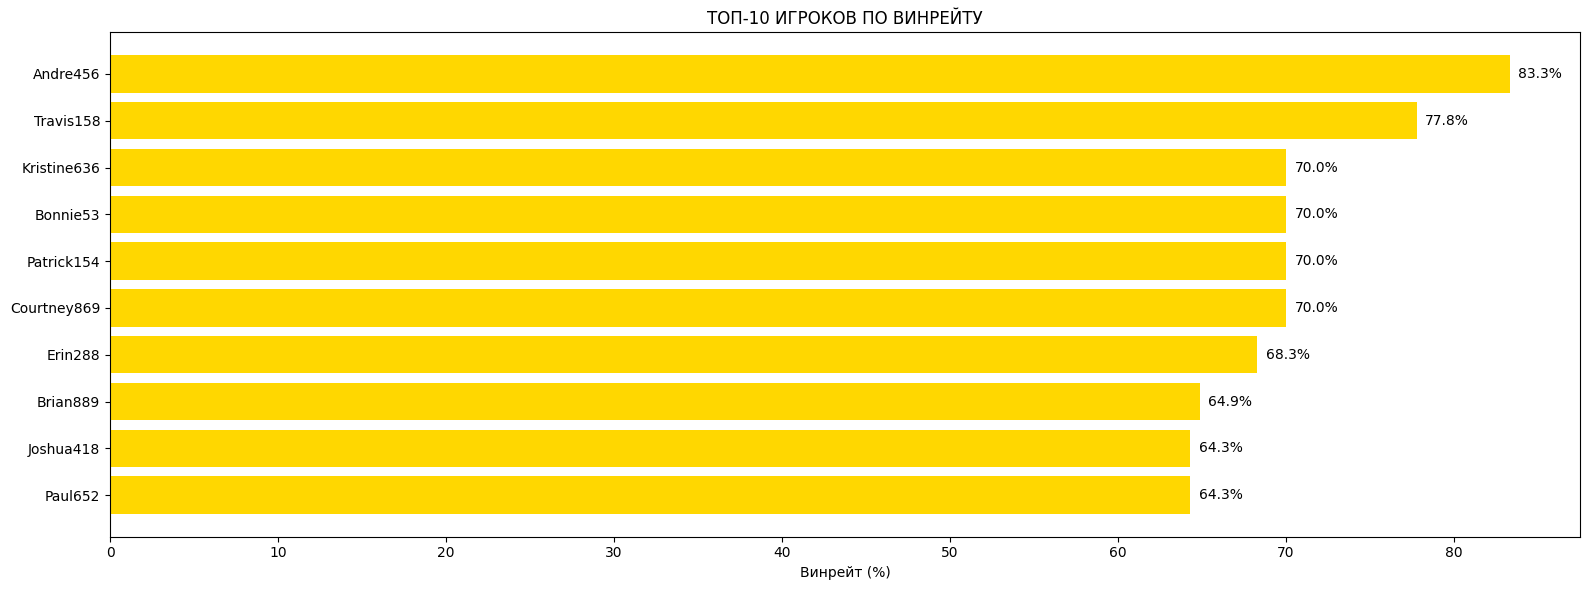

In [17]:
query = """
SELECT 
    u.summoner_name as player,
    COUNT(*) as total_matches,
    SUM(CASE WHEN mp.win THEN 1 ELSE 0 END) as wins,
    SUM(CASE WHEN NOT mp.win THEN 1 ELSE 0 END) as losses,
    ROUND(100.0 * SUM(CASE WHEN mp.win THEN 1 ELSE 0 END) / COUNT(*), 2) as win_rate_percent
FROM users u
JOIN match_participants mp ON u.id = mp.user_id
GROUP BY u.id, u.summoner_name
HAVING COUNT(*) >= 10
ORDER BY win_rate_percent DESC
LIMIT 10
"""
try:
    df_winrate = pd.read_sql(query, conn)
    print(df_winrate.to_string(index=False))

    fig, ax = plt.subplots(1, 1, figsize=(16, 6))

    bars = ax.barh(df_winrate['player'], df_winrate['win_rate_percent'], color='gold')
    ax.set_xlabel('Винрейт (%)')
    ax.set_title('ТОП-10 ИГРОКОВ ПО ВИНРЕЙТУ')
    ax.invert_yaxis()

    for bar in bars:
        width = bar.get_width()
        ax.text(width + 0.5, bar.get_y() + bar.get_height()/2, 
                f'{width:.1f}%', ha='left', va='center')

    plt.tight_layout()
    plt.show()
except Exception as e: 
    print(e)

# Статистика по позициям


🎮 СТАТИСТИКА ПО ПОЗИЦИЯМ
Средняя статистика по всем игрокам:
 avg_kills  avg_deaths  avg_assists  avg_kda
      12.5        7.43        19.95     4.37


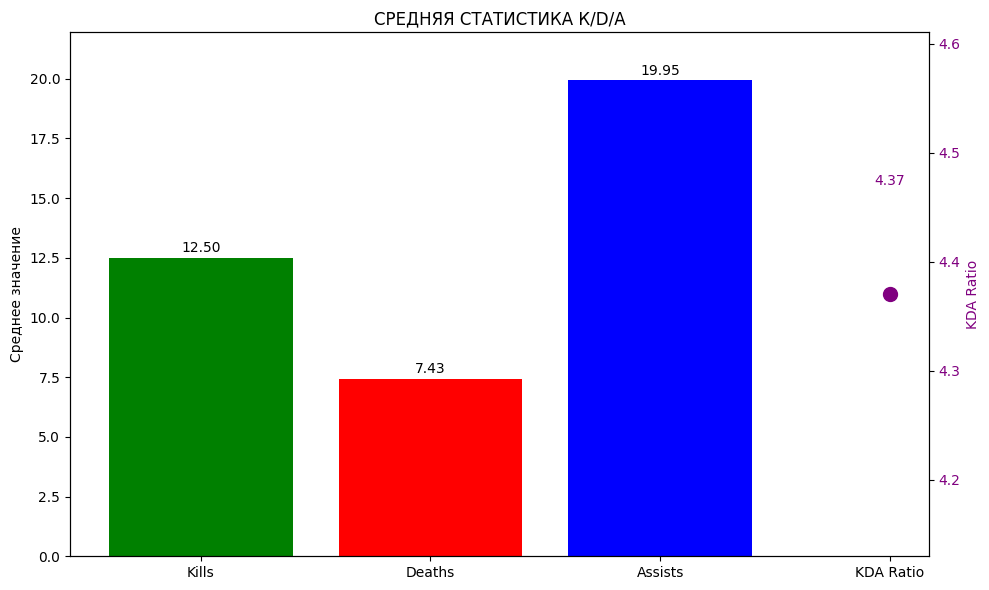

In [ ]:
query = """
SELECT 
    ROUND(AVG(kills), 2) as avg_kills,
    ROUND(AVG(deaths), 2) as avg_deaths,
    ROUND(AVG(assists), 2) as avg_assists,
    ROUND((AVG(kills) + AVG(assists)) / NULLIF(AVG(deaths), 0), 2) as avg_kda
FROM match_participants
"""

df_kda = pd.read_sql(query, conn)
print("Средняя статистика по всем игрокам:")
print(df_kda.to_string(index=False))

fig, ax = plt.subplots(figsize=(10, 6))
stats = ['Kills', 'Deaths', 'Assists', 'KDA Ratio']
values = [df_kda['avg_kills'].iloc[0], df_kda['avg_deaths'].iloc[0], 
          df_kda['avg_assists'].iloc[0], df_kda['avg_kda'].iloc[0]]

bars = ax.bar(stats[:3], values[:3], color=['green', 'red', 'blue'])
ax.set_ylabel('Среднее значение')
ax.set_title('СРЕДНЯЯ СТАТИСТИКА К/D/A')
ax.set_ylim(0, max(values[:3]) * 1.1)

for bar, val in zip(bars, values[:3]):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 0.1, 
           f'{val:.2f}', ha='center', va='bottom')

ax2 = ax.twinx()
ax2.plot(stats[3], values[3], 'o-', color='purple', markersize=10, linewidth=3)
ax2.set_ylabel('KDA Ratio', color='purple')
ax2.tick_params(axis='y', labelcolor='purple')
ax2.text(3, values[3] + 0.1, f'{values[3]:.2f}', ha='center', color='purple')

plt.tight_layout()
plt.show()